In [1]:
import warnings
from math import isclose
from timeit import timeit

import pandas as pd
import numpy as np
import plotly.graph_objects as go

In [2]:
# Disable warnings
warnings.filterwarnings('ignore')

## Data loading

In [3]:
query_df = pd.read_csv('qid_query.tsv', sep='\t', names = ['query_id','request'])

url_rating_df = pd.read_csv('qid_url_rating.tsv', sep='\t', names = ['query_id','url','rel'])

host_df = pd.read_csv('hostid_url.tsv', sep='\t', names = ['host_id','url'])

In [4]:
merged_df = pd.merge(url_rating_df, host_df, on="url")

## PFound realizations

In [5]:
def pFound(merged_df: pd.DataFrame, k: int) -> float:
    '''Calculate mean pFound of queries'''   
    # Select most relevant document for each host
    unique_hosts_df = merged_df\
        .groupby(['query_id','host_id'])\
        .rel.max().reset_index()

    # Sort by relevancy for each host  and get top k most relevant documents for each query                              
    top_k_df = unique_hosts_df\
        .sort_values(['query_id', 'rel'], ascending=False)\
        .groupby(['query_id']).head(k)
        
    # Set inner order for items grouped by queries
    top_k_df['order'] = top_k_df.groupby('query_id').cumcount()

    # Set break coefficient to 0.85 for each document
    top_k_df['break_coef'] = np.full(len(top_k_df), 0.85)
    # And set break coefficient to 1 for each first relevant document
    top_k_df.loc[top_k_df['order'] == 0, 'break_coef'] = 1
    
    # We need previous pRel to caltulate current pLook
    # So we can shift values of relevancy and set first values for each query to 0
    # Because there are no previous values for them
    top_k_df['rel_prev'] = top_k_df.groupby('query_id').rel.shift(1)
    top_k_df.fillna(0, inplace=True)
    
    
    # Set pLook to 1 (temporarily)
    top_k_df['p_look'] = np.ones(len(top_k_df))
    
    # At each step we multiply pLook by (1-pRel_prev)(1-pBreak)
    # So we can do it before consistently calculation of pLook
    top_k_df['p_look'] = top_k_df.p_look * top_k_df.break_coef * (1 - top_k_df.rel_prev)
    
    # And now we can consistently calculate pLook values as cummulative product 
    # of previous values ()
    top_k_df['p_look'] = top_k_df.groupby('query_id').p_look.cumprod()
    
    # Now we have to calculate components of final sums as product of pLook and pRel
    top_k_df['sum_component'] = top_k_df.p_look * top_k_df.rel
    
    # And finally we return mean value of sums for each query
    return top_k_df.groupby('query_id').sum_component.sum().mean()

In [6]:
def yandex_cup_pFound(k):
    qid_url_rating_hostid = pd.merge(url_rating_df, host_df, on="url")
    
    def plook(ind, rels):
        if ind == 0:
                    return 1
        return plook(ind-1, rels)*(1-rels[ind-1])*(1-0.15)

    def pfound(group):
        max_by_host = group.groupby("host_id")["rel"].max() # максимальный рейтинг хоста
        top10 = max_by_host.sort_values(ascending=False)[:k] # берем топ10 урлов с наивысшим рейтингом
        pfound = 0
        for ind, val in enumerate(top10):
                    pfound += val*plook(ind, top10.values)
        return pfound

    qid_pfound = qid_url_rating_hostid.groupby('query_id').apply(pfound) # группируем по qid и вычисляем pfound
    
    return qid_pfound.mean()

## Verification of correctness

In [7]:
k = 5

print(f'Mean pFound@{k} (Pandas): {pFound(merged_df, k)}')
print(f'Mean pFound@{k} (Naive): {yandex_cup_pFound(k)}')

print('Is equal:', isclose(pFound(merged_df,k), yandex_cup_pFound(k)))

Mean pFound@5 (Pandas): 0.4094605981825536
Mean pFound@5 (Naive): 0.40946059818255354
Is equal: True


## Performance check

In [8]:
df_rows = []
k_values = list(range(5, 70 + 1))

for k in k_values:
    df_rows.append({
        'k': k,
        'pandas': timeit(f'pFound(merged_df, {k})', globals=globals(), number = 1),
        'naive': timeit(f'yandex_cup_pFound({k})', globals=globals(), number = 1),
    })

execution_time_df = pd.DataFrame(df_rows)
    

In [9]:
execution_time_df

,k,pandas,naive
0,5,0.011972,0.021611
1,6,0.009955,0.018612
2,7,0.008361,0.017483
3,8,0.008061,0.017583
4,9,0.008430,0.017541
...,...,...,...
61,66,0.008133,0.023935
62,67,0.008021,0.024077
63,68,0.007993,0.023667
64,69,0.008044,0.023563


In [10]:
# Data fot line plotting
pandas = execution_time_df.pandas
naive = execution_time_df.naive

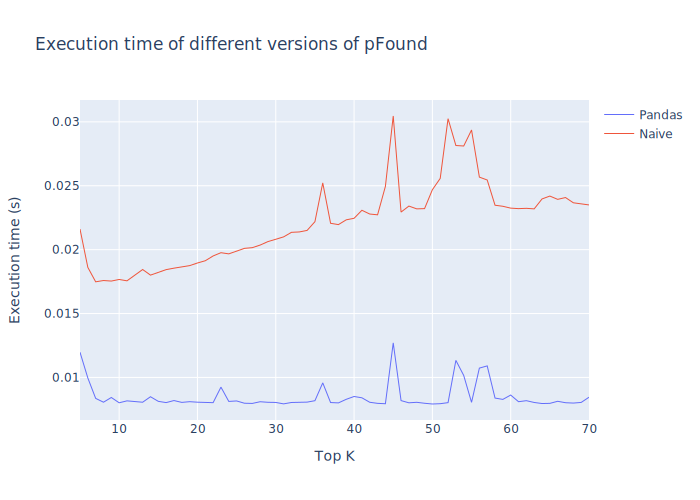

In [11]:
fig = go.Figure()
# Lines for naive and pandas implementation
fig.add_trace(go.Scatter(x=k_values, y=pandas, name='Pandas',
                         line=dict(width=1)))
fig.add_trace(go.Scatter(x=k_values, y=naive, name = 'Naive',
                         line=dict(width=1)))

# Editing the layout
fig.update_layout(title='Execution time of different versions of pFound')
fig.update_xaxes(title_text="Top K")
fig.update_yaxes(title_text="Execution time (s)")

fig.show("svg")